**MLDL Exp 4 - KNN Model**

--- BASELINE MATHEMATICAL RESULTS (k=5) ---
Accuracy : 93.00%
Precision: 89.47%
Recall   : 91.89%
F1 Score : 90.67%


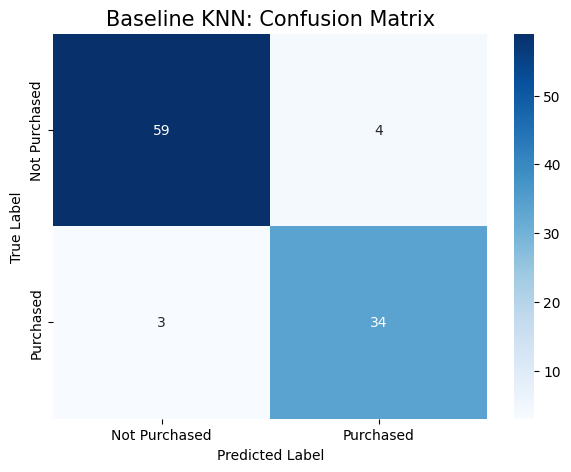

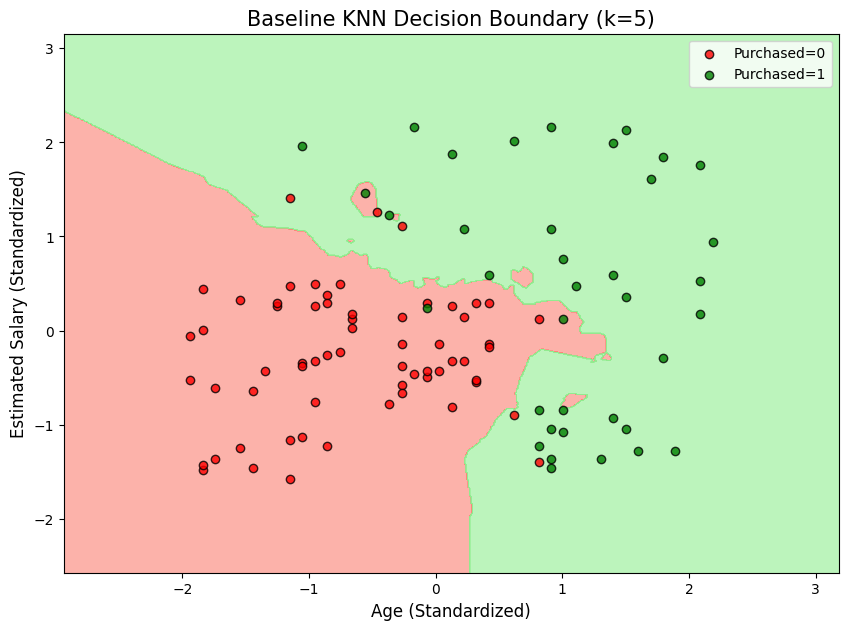

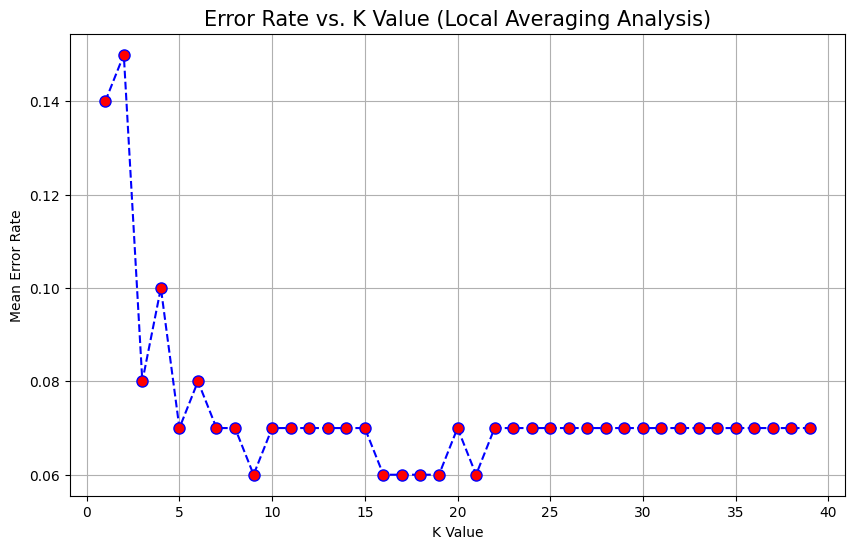

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from matplotlib.colors import ListedColormap

# ==========================================
# 1. LOAD AND PREPROCESS DATA
# ==========================================
# Loading dataset
df = pd.read_csv('Social_Network_Ads.csv')
X = df[['Age', 'EstimatedSalary']].values
y = df['Purchased'].values

# Split data into training (75%) and testing (25%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Feature Scaling (Standardization is mandatory for KNN due to distance calculations)
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

# Helper function for visualization of decision boundaries
def plot_decision_boundary(model, X_set, y_set, title, filename):
    X1, X2 = np.meshgrid(np.arange(start=X_set[:, 0].min() - 1, stop=X_set[:, 0].max() + 1, step=0.01),
                         np.arange(start=X_set[:, 1].min() - 1, stop=X_set[:, 1].max() + 1, step=0.01))
    plt.figure(figsize=(10, 7))
    plt.contourf(X1, X2, model.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
                 alpha=0.6, cmap=ListedColormap(('salmon', 'lightgreen')))
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())

    colors = ['red', 'green']
    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                    color=colors[i], label=f'Purchased={j}', edgecolor='black', alpha=0.8)

    plt.title(title, fontsize=15)
    plt.xlabel('Age (Standardized)', fontsize=12)
    plt.ylabel('Estimated Salary (Standardized)', fontsize=12)
    plt.legend()
    plt.savefig(filename)

# ==========================================
# 2. PART 1: BASELINE KNN (No Hyperparameters)
# ==========================================
# Baseline model using default k=5
baseline_knn = KNeighborsClassifier(n_neighbors=5)
baseline_knn.fit(X_train_scaled, y_train)
y_pred_baseline = baseline_knn.predict(X_test_scaled)

# Mathematical Metrics (Baseline)
baseline_acc = accuracy_score(y_test, y_pred_baseline) * 100
baseline_prec = precision_score(y_test, y_pred_baseline) * 100
baseline_rec = recall_score(y_test, y_pred_baseline) * 100
baseline_f1 = f1_score(y_test, y_pred_baseline) * 100

print("--- BASELINE MATHEMATICAL RESULTS (k=5) ---")
print(f"Accuracy : {baseline_acc:.2f}%")
print(f"Precision: {baseline_prec:.2f}%")
print(f"Recall   : {baseline_rec:.2f}%")
print(f"F1 Score : {baseline_f1:.2f}%")

# Visualization: Confusion Matrix
plt.figure(figsize=(7, 5))
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Purchased', 'Purchased'],
            yticklabels=['Not Purchased', 'Purchased'])
plt.title('Baseline KNN: Confusion Matrix', fontsize=15)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('baseline_confusion_matrix.png')

# Visualization: Decision Boundary
plot_decision_boundary(baseline_knn, X_test_scaled, y_test,
                       'Baseline KNN Decision Boundary (k=5)', 'baseline_decision_boundary.png')

# Visualization: Local Performance Curve (Error Rate vs K)
error_rate = []
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaled, y_train)
    pred_i = knn.predict(X_test_scaled)
    error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 40), error_rate, color='blue', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=8)
plt.title('Error Rate vs. K Value (Local Averaging Analysis)', fontsize=15)
plt.xlabel('K Value')
plt.ylabel('Mean Error Rate')
plt.grid(True)
plt.savefig('error_rate_vs_k.png')


--- TUNED MATHEMATICAL RESULTS ---
Best Configuration: {'metric': 'manhattan', 'n_neighbors': np.int64(9), 'weights': 'uniform'}
Accuracy : 94.00%
Precision: 87.80%
Recall   : 97.30%
F1 Score : 92.31%


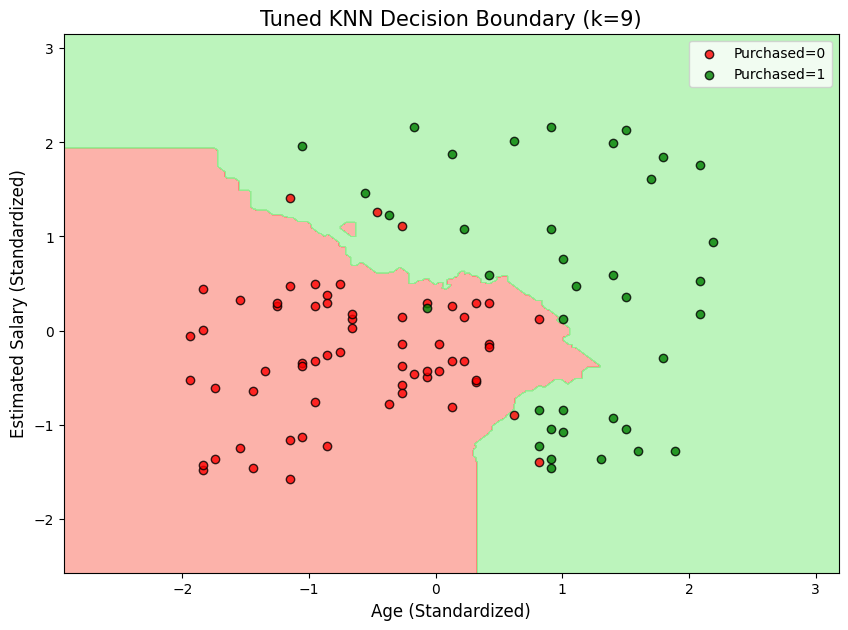

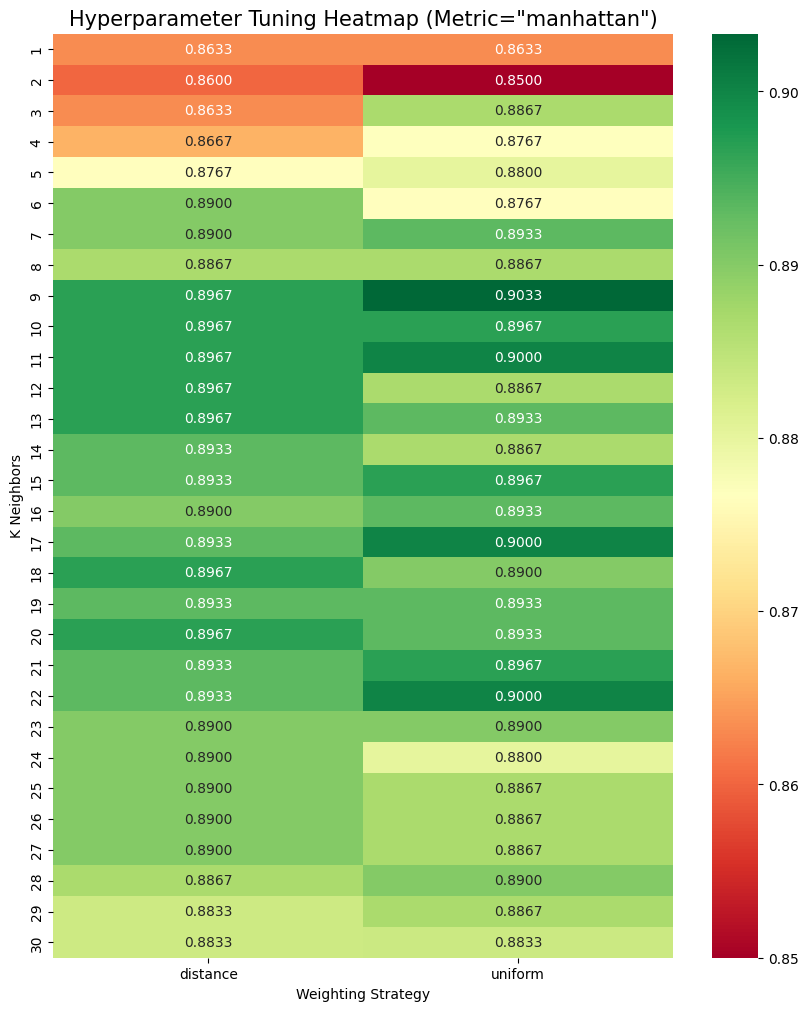

In [5]:
# ==========================================
# 3. PART 2: HYPERPARAMETER TUNING
# ==========================================
# Defining parameter grid for Grid Search
param_grid = {
    'n_neighbors': np.arange(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_knn = grid_search.best_estimator_
y_pred_tuned = best_knn.predict(X_test_scaled)

# Mathematical Metrics (Tuned)
tuned_acc = accuracy_score(y_test, y_pred_tuned) * 100
tuned_prec = precision_score(y_test, y_pred_tuned) * 100
tuned_rec = recall_score(y_test, y_pred_tuned) * 100
tuned_f1 = f1_score(y_test, y_pred_tuned) * 100
best_params = grid_search.best_params_

# Visualization: Tuned Decision Boundary
plot_decision_boundary(best_knn, X_test_scaled, y_test,
                       f'Tuned KNN Decision Boundary (k={best_params["n_neighbors"]})', 'tuned_decision_boundary.png')

# Visualization: Hyperparameter Tuning Heatmap
results_df = pd.DataFrame(grid_search.cv_results_)
best_metric = best_params['metric']
subset = results_df[results_df['param_metric'] == best_metric]
pivot_table = subset.pivot(index='param_n_neighbors', columns='param_weights', values='mean_test_score')

plt.figure(figsize=(10, 12))
sns.heatmap(pivot_table, annot=True, cmap='RdYlGn', fmt=".4f")
plt.title(f'Hyperparameter Tuning Heatmap (Metric="{best_metric}")', fontsize=15)
plt.ylabel('K Neighbors')
plt.xlabel('Weighting Strategy')
plt.savefig('tuning_heatmap.png')

# Final Console Output
print("\n--- TUNED MATHEMATICAL RESULTS ---")
print(f"Best Configuration: {best_params}")
print(f"Accuracy : {tuned_acc:.2f}%")
print(f"Precision: {tuned_prec:.2f}%")
print(f"Recall   : {tuned_rec:.2f}%")
print(f"F1 Score : {tuned_f1:.2f}%")